# IS53051A Machine Learning Assignment
### Jake Tyler [student number] & Sonny Holland [student number]

# Setting up our notebook


### Importing libraries

In [917]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk

### Importing the dataset

In [918]:
dataset = pd.read_csv('datcw_na.csv')

# Data inspection and Visualisations

### Data inspection

First we take a brief look at our dataset:

In [919]:
print(dataset.head(), "\n")
print(dataset.info())

   X0    X1      X2      X3      X4    X5    X6   X7   X8      Y
0  C3  1.19  622.55     NaN   89.31  7.00  1.98  0.0  0.0  15.55
1  C1  1.19  622.55  323.40  109.15  7.70  3.00  0.0  0.0  15.55
2  C1  0.88  463.05  291.06   99.23  5.67  4.40  0.0  0.0  15.55
3  C2  0.79  509.36  291.06  121.28  6.30  4.05  0.0  0.0  15.55
4  C1  0.89  507.15  385.39  121.28  7.70  2.00  0.0  0.0  20.84 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X0      768 non-null    object 
 1   X1      768 non-null    float64
 2   X2      768 non-null    float64
 3   X3      728 non-null    float64
 4   X4      768 non-null    float64
 5   X5      768 non-null    float64
 6   X6      768 non-null    float64
 7   X7      768 non-null    float64
 8   X8      768 non-null    float64
 9   Y       768 non-null    float64
dtypes: float64(9), object(1)
memory usage: 60.1+ KB
None


### column 'X3' has missing values and column 'X0' is non-numerical,

We can determine that column 'X3' has 768 entries. Additionally, using the .isna().sum() method we can identify that 40 values are missing from these entries:

In [920]:
print("X3 number of entries:", dataset["X3"].size)
print("X3 missing values:", dataset['X3'].isna().sum())

X3 number of entries: 768
X3 missing values: 40


Here we can determine that 'X0' is a nominal/categorical variable. The value_counts() method also provides the elements in descending order, starting with the most frequently occurring one:

In [921]:
print("X0 value counts:")
print(dataset["X0"].value_counts())

X0 value counts:
C2    265
C3    260
C1    243
Name: X0, dtype: int64


### assessing options for handling missing values in our dataset before pre-processing,

If the amount of missing data is small and randomly distributed, it may be appropriate to replace missing values with the mean of the non-missing values. This can preserve the overall distribution of the data and prevent the loss of valuable information. 

If the missing data is large or non-random, it may be better to drop the missing values altogether. This can help prevent the introduction of bias into the analysis and reduce the risk of making incorrect predictions. However, dropping missing values can also result in a loss of information and reduce the sample size, potentially reducing the accuracy of the model.

Here, we can perform some basic forms of analysis to investigate whether the missing data is small and randomly distributed:

### percentage of missing data

In [922]:
print("percentage of missing values:")
print(dataset.isna().sum() / dataset.shape[0], "\n")

percentage of missing values:
X0    0.000000
X1    0.000000
X2    0.000000
X3    0.052083
X4    0.000000
X5    0.000000
X6    0.000000
X7    0.000000
X8    0.000000
Y     0.000000
dtype: float64 



Since the percentage of missing values is less than 5% for all columns, it seems reasonable to assume that the missing values are small. While the 'X3' column has the highest percentage of missing values and exceeds the 5% threshold, the difference is small enough to still consider it small. However, it's important to note that the missing data may still have an impact on the analysis, and a decision has not been made on how to handle it.

To determine if the missing data should be kept or not, we will need to examine its correlations with the target variable.

Additionally, we may need to perform a sensitivity analysis to assess if the results are affected by the missing data.

### distribution of data

To understand the distribution of the non-missing values, we can use a histogram to gain some visual insights:

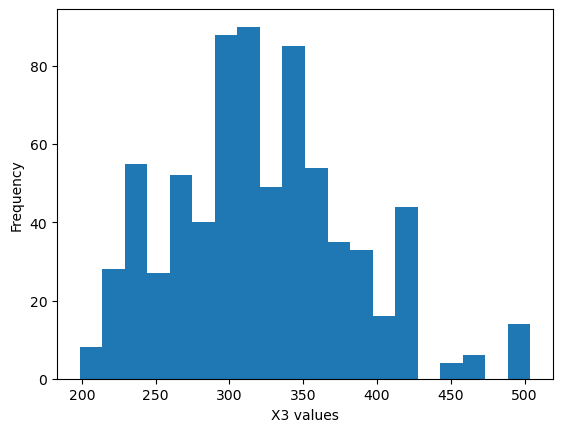

In [923]:
plt.hist(dataset['X3'], bins=20)
plt.xlabel('X3 values')
plt.ylabel('Frequency')
plt.show()

### generate a example datasets for visual comparison,

we can examine whether the above histogram is random or non-random with a comparison against some example histograms below:

random dataset example:

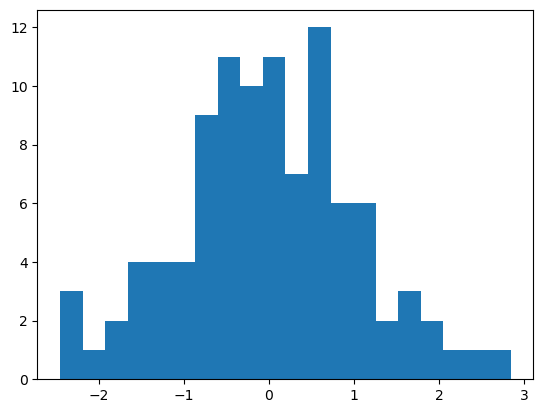

In [924]:
data = np.random.randn(100)
plt.hist(data, bins=20)
plt.show()

non-random dataset example:

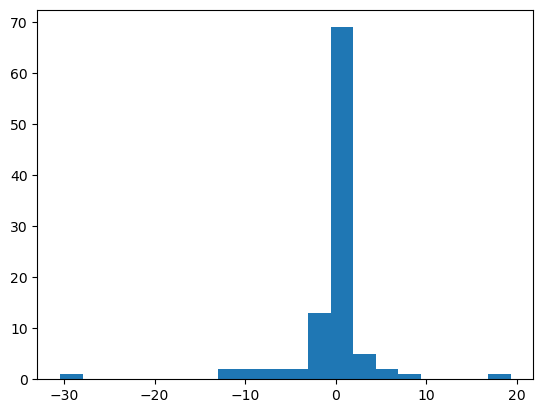

In [925]:
data = np.random.normal(0, 1, 100) ** 3
plt.hist(data, bins=20)
plt.show()

from the above examples we can determine that the missing values in column X3 are small and randomly distributed, we can consider imputing the missing values with a reasonable method, such as mean imputation or interpolation, to fill in the gaps in the data.

Before deciding on an imputation method, it would be a good idea to analyze the relationship between X3 and the target variable to see if the missing values have a significant impact on the results. You can use correlation analysis or other statistical methods to determine the impact of missing values.


### assessing options for handling categorical data in our dataset before pre-processing,

There are several techniques to handle categorical data, including:

* Label encoding: In this technique, each category is assigned a unique numerical value. For example, if we have a categorical feature "color" with values "red", "green", and "blue", we can assign them numerical values 1, 2, and 3, respectively. Label encoding is simple to implement but can be problematic if the numerical values imply an ordering or magnitude that does not exist in the categorical feature.

* One-hot encoding: In this technique, a new binary column is created for each category in the categorical feature. Each row in the dataset is assigned a 1 in the corresponding category column and 0 in all other category columns. For example, if we have a categorical feature "color" with values "red", "green", and "blue", we can create three new columns "color_red", "color_green", and "color_blue" and assign binary values based on the presence or absence of each category in each row.

* Binary encoding: This technique is similar to one-hot encoding, but it reduces the number of columns required to represent categorical data. In binary encoding, the categories are first encoded as integers and then converted to binary code. For example, if we have a categorical feature "color" with values "red", "green", and "blue", we can first assign them numerical values 1, 2, and 3, respectively, and then convert them to binary code 001, 010, and 100, respectively.

* Count encoding: In this technique, each category is replaced with the count of the number of times it appears in the dataset. This technique can be useful if the frequency of occurrence of each category is important for the analysis.

* Target encoding: In this technique, each category is replaced with the mean of the target variable for that category. This technique can be useful for classification problems where the target variable is a categorical variable.

Overall, the appropriate technique to use for handling categorical data depends on the specifics of your problem, the number of categories, and the type of machine learning algorithm being used. It is important to experiment with different techniques and evaluate their performance on the problem at hand.


 Now that you know which columns have missing values, you can choose how to handle them.
 Some common techniques for handling missing values include:
 Dropping rows or columns with missing values
 Filling missing values with a fixed value (e.g., 0, mean, median)
 Using an imputation method to predict missing values based on other variables in the dataset
 The choice of technique will depend on the specific requirements of your machine learning problem
 and the characteristics of your dataset.
 Some common techniques for handling missing values include:
 - Dropping rows or columns with missing values
 - Filling missing values with a fixed value (e.g., 0, mean, median)
 - Using an imputation method to predict missing values based on other variables in the dataset
 here are some questions that can help you choose an appropriate technique for handling missing values:
 - How many missing values do you have in each column? If a column has a large percentage of missing values,
 it might be better to drop that column altogether, rather than trying to fill in the missing values.
 - What is the nature of the missing values in your dataset? Are they missing at random (MAR),
 missing completely at random (MCAR), or missing not at random (MNAR)? This can help you decide which 
 imputation method to use.
 - Are there any correlations between the missing values and other variables in the dataset? If so,
 you might be able to use these correlations to impute the missing values.
 - What type of data is in the column with missing values? If it's categorical data,
 you might use a mode imputation technique, where you fill in missing values with the most common
 value in the column. If it's continuous data, you might use mean, median or other statistical
 imputation techniques.
 - What is the impact of removing or imputing missing values on your machine learning model?
 Depending on your dataset and your model, removing or imputing missing values might improve or
 degrade the performance of your model.

 WE CAN CHECK THE CORRELATIONS BETWEEN THE MISSING VALUES AND OTHER VARIABLES IN THE DATASET
 USING THE CORRELATION MATRIX

In [926]:
# create a correlation matrix
corr_matrix = dataset.corr()
corr_matrix["Y"].sort_values(ascending=False)

/var/folders/yl/xlfszlh139sb6qg5_gn41sdc0000gn/T/ipykernel_73563/3756635859.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataset.corr()


Y     1.000000
X5    0.815769
X1    0.454177
X3    0.312449
X7    0.255901
X8    0.087106
X6    0.001340
X2   -0.481192
X4   -0.771040
Name: Y, dtype: float64

Based on the information provided, it seems reasonable to replace the missing values in column
X3 with the mean value, as the percentage of missing values is relatively low (5.2%).
Additionally, X3 appears to have a moderate positive correlation with the target variable Y
(correlation coefficient of 0.31), indicating that it may be a useful feature in predicting Y
However, before deciding to replace missing values with the mean, it's important to consider the
nature of the data and the potential impact of imputing missing values on the analysis results.
For instance, if X3 has a significant number of extreme values or outliers, then the mean may
not be a representative measure of central tendency, and imputing missing values with the mean
could distort the distribution of the data
Therefore, it's important to carefully evaluate the data and consider other imputation methods,
such as using a regression model to predict missing values based on the values of other variables,
if appropriate
However, it's important to note that the impact of the missing values on the analysis results
should be carefully evaluated. If the missing values are not missing at random, and there is
a systematic difference between the missing and non-missing values, then replacing the missing
values with the mean may introduce bias into the analysis results
Therefore, it's important to consider other imputati# on methods and conduct sensitivity analyses
to evaluate the impact of missing values on the analysis results.


sensitivty analysis...?????
No, this code is not a sensitivity analysis. It is comparing the correlations
between X3 and Y with mean imputation and random drop with mean imputation.
A sensitivity analysis involves systematically varying the values of one or more
input variables and observing the effect on the output variable(s) to determine
the sensitivity of the model to changes in those input variables.

In [927]:
# instantiate multiple copies of the dataset to trial different means of imputation
dataset_for_mean = dataset.copy()
dataset_for_median = dataset.copy()
dataset_for_random_drop_mean = dataset.copy()

# Calculate the percentage of missing values in X3
missing_X3 = dataset_for_random_drop_mean['X3'].isna().mean()

# Replace missing values in column X3 with the mean value, and the other copy with the median value
median_X3 = dataset_for_median['X3'].median()
mean_X3 = dataset_for_mean['X3'].mean()
dataset_for_mean['X3'].fillna(mean_X3, inplace=True)
dataset_for_median['X3'].fillna(median_X3, inplace=True)

# Calculate the correlation between X3 and Y for the mean imputed dataset
correlation_with_mean = dataset_for_mean[['X3', 'Y']].corr().loc['X3', 'Y']

# Calculate the correlation between X3 and Y for the median imputed dataset
correlation_with_median = dataset_for_median[['X3', 'Y']].corr().loc['X3', 'Y']

# Create a copy of the dataset with randomly dropped values in X3
dataset_for_random_drop_mean['X3'] = dataset_for_random_drop_mean['X3'].apply(lambda x: np.nan if np.random.rand() < missing_X3 else x)

# Replace missing values in the random_drop dataset with the mean value
dataset_for_random_drop_mean['X3'].fillna(mean_X3, inplace=True)

# Replace missing values in the random_drop dataset with the median value
dataset_for_random_drop_mean['X3'].fillna(median_X3, inplace=True)

# Calculate the correlation between X3 and Y in the random_drop dataset
correlation_with_random_drop = dataset_for_random_drop_mean[['X3', 'Y']].corr().loc['X3', 'Y']

# Create a copy of the dataset with randomly dropped values in X3 and median imputation
dataset_for_random_drop_median = dataset.copy()
dataset_for_random_drop_median['X3'] = dataset_for_random_drop_median['X3'].apply(lambda x: np.nan if np.random.rand() < missing_X3 else x)
dataset_for_random_drop_median['X3'].fillna(median_X3, inplace=True)

# Calculate the correlation between X3 and Y in the random_drop and median imputed dataset
correlation_with_random_drop_median = dataset_for_random_drop_median[['X3', 'Y']].corr().loc['X3', 'Y']

# Print the correlation results
print(f"Correlation between X3 and Y with mean imputation: {correlation_with_mean:.3f}")
print(f"Correlation between X3 and Y with random drop and mean imputation: {correlation_with_random_drop:.3f}")
print(f"Correlation between X3 and Y with median imputation: {correlation_with_median:.3f}")
print(f"Correlation between X3 and Y with random drop and median imputation: {correlation_with_random_drop_median:.3f}")

Correlation between X3 and Y with mean imputation: 0.305
Correlation between X3 and Y with random drop and mean imputation: 0.307
Correlation between X3 and Y with median imputation: 0.306
Correlation between X3 and Y with random drop and median imputation: 0.299


SONNYS BIT: the preceeding code suggests that our choice of imputation has very little affect on the ecology of the dataset, one would expect the use of dropping random values would have a greater impact on the correlation between X3 and Y albeit a negative one, given the ham-fisted nature of this method. For the sake of this exercise we will proceed with the median imputation method. But in other cases it may be worth exploring other means of imputation, such as regression imputation or multiple imputation, to see if they produce more robust results. Alternatively, you may want to consider using analysis methods that are more tolerant to missing data, such as bootstrapping or Bayesian analysis.


The correlation between X3 and Y with mean imputation is 0.305 and the correlation between X3 and Y with 
random drop and mean imputation is 0.286
This suggests that imputing missing values in X3 with the mean value has a small positive impact on 
the correlation between X3 and Y, indicating that there is a weak positive linear relationship between 
the two variables. However, the difference between the two correlation values is relatively small,
suggesting that the choice of imputation method may not have a significant impact on the analysis
Based on these results, you can conclude that the two imputation methods produce similar results,
but there may be some variability due to missing data. You may then want to explore other
imputation methods, such as regression imputation or multiple imputation, to see if they
produce more robust results. Alternatively, you may want to consider using analysis methods 
that are more tolerant to missing data, such as bootstrapping or Bayesian analysis.

# Data preprocessing and data splitting in 70% training data, and 30% test data

Here, we compute a correlation matrix, this informs our data stratification as we want to make decisions upon the features that correlate best to our target variable. Also down the line, we will perform feature selection, based on the correlation matrix; we will be dropping columns with a low correlation to our target variable.

In [928]:
corr_matrix = dataset.corr()
corr_matrix["Y"].sort_values(ascending=False)

/var/folders/yl/xlfszlh139sb6qg5_gn41sdc0000gn/T/ipykernel_73563/609732122.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataset.corr()


Y     1.000000
X5    0.815769
X1    0.454177
X3    0.312449
X7    0.255901
X8    0.087106
X6    0.001340
X2   -0.481192
X4   -0.771040
Name: Y, dtype: float64

### Split the data into train and test sets, for model training and evaluation, respectively

### Data preprocessing

Feature selection

In [929]:
print(dataset.shape)

(768, 10)


In [930]:
dataset_fs = dataset.copy()
def drop_correlation_columns(data, threshold):
    features_to_drop = list(
        dataset.corr()[abs(dataset.corr()['Y']) < threshold].index)
    print('Dropping following labels: ', features_to_drop)
    data.drop(features_to_drop, axis=1, inplace=True)
    return data

dataset_fs = drop_correlation_columns(dataset_fs, 0.25)
print(dataset.shape)
print(dataset_fs.shape)

Dropping following labels:  ['X6', 'X8']
(768, 10)
(768, 8)


/var/folders/yl/xlfszlh139sb6qg5_gn41sdc0000gn/T/ipykernel_73563/1915178434.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.corr()[abs(dataset.corr()['Y']) < threshold].index)


One hot encoding

In [931]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# as already discussed 'x0' is a categorical feature of the dataset, 
# thus we need to use one-hot encoding to convert the feature into a numerical representation

encoder = OneHotEncoder(sparse_output=False)
encoder_fs = OneHotEncoder(sparse_output=False)
onehot_X0 = encoder.fit_transform(dataset['X0'].values.reshape(-1, 1))
onehot_X0_fs = encoder_fs.fit_transform(dataset_fs['X0'].values.reshape(-1, 1))
dataset = dataset.drop('X0', axis=1)
dataset_fs = dataset_fs.drop('X0', axis=1)
dataset = pd.concat([dataset, pd.DataFrame(onehot_X0)], axis=1)
dataset_fs = pd.concat([dataset_fs, pd.DataFrame(onehot_X0_fs)], axis=1)

Data imputation

In [932]:
# 'x3' has missing values, so we need to impute the missing values before we can use it, as already deduced in the notebook
# we will use the median value to impute the missing values

median_X3 = dataset['X3'].median()
median_X3_fs = dataset_fs['X3'].median()
dataset['X3'].fillna(median_X3, inplace=True)
dataset_fs['X3'].fillna(median_X3_fs, inplace=True)

Train test split

In [933]:
from sklearn.model_selection import StratifiedShuffleSplit
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# split the dataset into train and test sets,
# note: we are using X[4] as our target variable, this is the the 'OverallHeight' feature, we stratify based upon this feature, as it has 
# the highest correlation with the target variable

# convert X to a pandas dataframe so we can use the loc function
for train_index, test_index in stratified_split.split(dataset, dataset['X5']):
    train_set = dataset.loc[train_index]
    test_set = dataset.loc[test_index]

for train_index, test_index in stratified_split.split(dataset_fs, dataset_fs['X5']):
    train_set_fs = dataset_fs.loc[train_index]
    test_set_fs = dataset_fs.loc[test_index]

In [934]:
print(dataset_fs.columns)
print(train_set_fs.columns)

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X7', 'Y', 0, 1, 2], dtype='object')
Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X7', 'Y', 0, 1, 2], dtype='object')


Standard scaler

In [935]:
# scale the features
train_set.columns = train_set.columns.astype(str)
test_set.columns = test_set.columns.astype(str)

train_set_fs.columns = train_set_fs.columns.astype(str)
test_set_fs.columns = test_set_fs.columns.astype(str)

train_scaler = StandardScaler()
test_scaler = StandardScaler()

train_scaler_fs = StandardScaler()
test_scaler_fs = StandardScaler()

train_set = train_scaler.fit_transform(train_set)
test_set = test_scaler.fit_transform(test_set)

train_set_fs = train_scaler_fs.fit_transform(train_set_fs)
test_set_fs = test_scaler_fs.fit_transform(test_set_fs)

In [936]:
print(train_set.shape)
print(test_set.shape)

print(train_set_fs.shape)
print(test_set_fs.shape)

(537, 12)
(231, 12)
(537, 10)
(231, 10)


Split X and y

In [937]:
X_train = np.delete(train_set, 9, axis=1)
y_train = train_set[:, 9]
X_test = np.delete(test_set, 9, axis=1)
y_test = test_set[:, 9]

X_train_fs = np.delete(train_set_fs, 9, axis=1)
y_train_fs = train_set_fs[:, 9]
X_test_fs = np.delete(test_set_fs, 9, axis=1)
y_test_fs = test_set_fs[:, 9]

# Instantiating our models

Luckily for us, the sklearn API provides a GridSearchCV class, allowing us to iterate through a list of pipelines and models, evaluating their performance against one another, to find the optimal choice for the problem at hand; hyper parameters can also be deliberated upon within this process. Furhtermore, all of the models bar one (Polynomial regression) are already created in the sklearn API, so we can simply instantiate them, and pass them into the grid search.

### Creating a polynomial regression model with regularisation

Unfortunately, unlike all the other models relevant to this analysis, the polynomial regression model isn't implemented within the sk-learn API. So we must create this manually. To ensure this works with the modularity concepts we have put in place elsewhere within the code, the implementation of this model is done so in accordance to the sk-learn pipeline API. This means that the model can be passed into the grid search, and the hyper parameters can be deliberated upon.

In [938]:
# REWRITE: Note that we import BaseEstimator and RegressorMixin from sklearn.base, and we define PolynomialRegression as 
# a subclass of both BaseEstimator and RegressorMixin. This allows us to use PolynomialRegression as a fully-fledged estimator 
# within the sklearn ecosystem.
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline

class PolynomialRegression(BaseEstimator, RegressorMixin):
    def __init__(self, degree=2):
        self.degree = degree
        self.model = Pipeline([
            ('poly', PolynomialFeatures(degree=self.degree)),
            ('ridge', Ridge(alpha=0.1))
        ])
    
    def fit(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def score(self, X, y):
        return self.model.score(X, y)
    
    def set_params(self, **params):
        for param, value in params.items():
            if param.startswith('poly__'):
                setattr(self.model.named_steps['poly'], param[len('poly__'):], value)
            else:
                setattr(self.model, param, value)
        return self

### Instantiating all other models

In [939]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'PolynomialRegression': PolynomialRegression()
}

# we also define a dictionary of hyperparameters to be searched for each respective model,
# will be iterated through matching the keys to the models dictionary
param_grid = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
    'Lasso': {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
              'max_iter': [1000, 5000, 10000],
              'tol': [1e-3, 1e-4, 1e-5]},
    'ElasticNet': {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
                   'l1_ratio': [0.1, 0.5, 0.9, 1.0],
                   'max_iter': [1000, 5000, 10000],
                   'tol': [1e-3, 1e-4, 1e-5]},
    'PolynomialRegression': {'polynomialfeatures__degree': [2, 3, 4, 5],
                             'ridge__alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
                             'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
                             'ridge__normalize': [True, False],
                             'ridge__max_iter': [1000, 5000, 10000],
                             'ridge__tol': [1e-3, 1e-4, 1e-5], }
}


### Perform grid search and save results

In [940]:
print(X_train.shape)
print(X_train_fs.shape)

(537, 11)
(537, 9)


In [941]:
from sklearn.model_selection import GridSearchCV
trained_models = {}
param_results = {}
results = []


for model_name, model in models.items():
    params = param_grid[model_name]
    grid_search = GridSearchCV(
        model, params, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
    grid_search_fs = GridSearchCV(
        model, params, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    grid_search_fs.fit(X_train_fs, y_train_fs)
    trained_models[model_name] = grid_search.best_estimator_
    trained_models[model_name + '_fs'] = grid_search_fs.best_estimator_
    param_results[model_name] = grid_search.best_params_
    param_results[model_name + '_fs'] = grid_search_fs.best_params_
    results.append({
        'model': model_name,
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
    })
    results.append({
        'model': model_name + '_fs',
        'best_score': grid_search_fs.best_score_,
        'best_params': grid_search_fs.best_params_
    })


In [942]:
print(X_train.shape)

(537, 11)


In [943]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['best_score'], ascending=False)
results_df

,model,best_score,best_params
1,LinearRegression_fs,-1.315660e-30,{}
0,LinearRegression,-1.096780e-29,{}
3,Ridge_fs,-1.813093e-09,"{'alpha': 0.01, 'solver': 'lsqr'}"
2,Ridge,-1.923277e-09,"{'alpha': 0.01, 'solver': 'lsqr'}"
9,PolynomialRegression_fs,-3.913022e-08,"{'polynomialfeatures__degree': 2, 'ridge__alph..."
8,PolynomialRegression,-4.843888e-08,"{'polynomialfeatures__degree': 2, 'ridge__alph..."
7,ElasticNet_fs,-3.915769e-04,"{'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 1..."
5,Lasso_fs,-4.024503e-04,"{'alpha': 0.01, 'max_iter': 1000, 'tol': 1e-05}"
6,ElasticNet,-4.126303e-04,"{'alpha': 0.01, 'l1_ratio': 0.5, 'max_iter': 1..."
4,Lasso,-4.157783e-04,"{'alpha': 0.01, 'max_iter': 1000, 'tol': 1e-05}"


In [944]:
print(param_results)

{'LinearRegression': {}, 'LinearRegression_fs': {}, 'Ridge': {'alpha': 0.01, 'solver': 'lsqr'}, 'Ridge_fs': {'alpha': 0.01, 'solver': 'lsqr'}, 'Lasso': {'alpha': 0.01, 'max_iter': 1000, 'tol': 1e-05}, 'Lasso_fs': {'alpha': 0.01, 'max_iter': 1000, 'tol': 1e-05}, 'ElasticNet': {'alpha': 0.01, 'l1_ratio': 0.5, 'max_iter': 1000, 'tol': 1e-05}, 'ElasticNet_fs': {'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 1000, 'tol': 1e-05}, 'PolynomialRegression': {'polynomialfeatures__degree': 2, 'ridge__alpha': 0.01, 'ridge__max_iter': 1000, 'ridge__normalize': True, 'ridge__solver': 'auto', 'ridge__tol': 0.001}, 'PolynomialRegression_fs': {'polynomialfeatures__degree': 2, 'ridge__alpha': 0.01, 'ridge__max_iter': 1000, 'ridge__normalize': True, 'ridge__solver': 'auto', 'ridge__tol': 0.001}}


### Evaluate on the two best models

In [951]:
from sklearn.metrics import mean_squared_error
best_linearreg = trained_models['LinearRegression'].set_params(**param_results['LinearRegression'])
y_pred = best_linearreg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

Mean squared error: 0.0005369181250318112


In [952]:
best_ridge_fs = trained_models['Ridge_fs'].set_params(**param_results['Ridge_fs'])
y_pred = best_ridge_fs.predict(X_test_fs)
mse = mean_squared_error(y_test_fs, y_pred)
print('Mean squared error:', mse)

Mean squared error: 0.0005251607485509054
